In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from collections import Counter
import warnings
import datetime
from scipy import stats

warnings.filterwarnings('ignore')

# Set up Chinese font support for matplotlib
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

print("Libraries imported successfully!")
print(f"Analysis started at: {datetime.datetime.now()}")


Libraries imported successfully!
Analysis started at: 2025-11-06 16:07:31.583427


In [2]:
# Define empathy keywords for three dimensions
EMPATHY_KEYWORDS = {
    'perspective_taking': [
        '你是', '你想', '你的', '根据你', '对于你', '你可能', '你希望', 
        '你觉得', '你认为', '你需要', '从你的角度', '站在你的', '理解你的',
        '你会', '你应该', '你提到', '你说的', '你关心', '你担心', '你期望'
    ],
    'concern_to_help': [
        '建议', '推荐', '帮你', '为你', '给你', '协助', '指导', '支持',
        '解决', '提供', '安排', '规划', '制定', '整理', '准备',
        '可以试试', '不妨', '或许可以', '建议你', '推荐你', '帮助你'
    ],
    'affective_empathy': [
        '别着急', '不要担心', '放心', '理解', '感受', '体会', '共鸣',
        '同感', '心情', '感觉', '情绪', '开心', '高兴', '满意',
        '遗憾', '可惜', '抱歉', '歉意', '温馨', '贴心', '暖心', '理解您'
    ]
}

# Define file paths
FEEDBACK_PATH = '/Users/ericwang/git/mics/empathy/回答反馈.csv'
EXCEL_FILES = [
    '/Users/ericwang/git/mics/empathy/北海智伴对话_250501-0520.xlsx',
    '/Users/ericwang/git/mics/empathy/北海智伴对话_250521-0610.xlsx',
    '/Users/ericwang/git/mics/empathy/北海智伴对话_250611-0620.xlsx',
    '/Users/ericwang/git/mics/empathy/北海智伴对话_250621-0701.xlsx'
]

print("Configuration completed!")
print(f"Empathy dimensions: {list(EMPATHY_KEYWORDS.keys())}")
print(f"Data files: {len(EXCEL_FILES)} Excel files + 1 CSV file")


Configuration completed!
Empathy dimensions: ['perspective_taking', 'concern_to_help', 'affective_empathy']
Data files: 4 Excel files + 1 CSV file


In [3]:
def load_feedback_data(feedback_path):
    """Load and preprocess feedback data"""
    print("Loading feedback data...")
    df_feedback = pd.read_csv(feedback_path)
    
    print(f"Original feedback records: {len(df_feedback)}")
    
    # Filter Beihai data (travel_id=40)
    df_feedback = df_feedback[df_feedback['travel_id'] == 40].copy()
    print(f"Beihai feedback records: {len(df_feedback)}")
    
    # Filter valid feedback states (1: like, 2: dislike, 0: cancelled)
    df_feedback = df_feedback[df_feedback['feedback_state'].isin([1, 2])].copy()
    print(f"Valid feedback records (likes/dislikes): {len(df_feedback)}")
    
    # Show feedback distribution
    feedback_counts = df_feedback['feedback_state'].value_counts()
    print(f"\nFeedback distribution:")
    print(f"  Likes (feedback_state=1): {feedback_counts.get(1, 0)}")
    print(f"  Dislikes (feedback_state=2): {feedback_counts.get(2, 0)}")
    
    return df_feedback

# Load feedback data
df_feedback = load_feedback_data(FEEDBACK_PATH)
df_feedback.head()


Loading feedback data...
Original feedback records: 1254
Beihai feedback records: 793
Valid feedback records (likes/dislikes): 743

Feedback distribution:
  Likes (feedback_state=1): 282
  Dislikes (feedback_state=2): 461


,id,creator,create_time,feedback,im_id,feedback_state,travel_id
0,756,2111805245515981,2024-04-28 03:09:50,NaN,c64fa7e0-c313-4579-8a35-1e2c1508707e,1,40
1,757,2111805245515981,2024-04-28 03:38:31,NaN,e5dd52b7-bb4e-4ec8-9835-1750b977e928,2,40
3,759,2111805245515981,2024-04-28 03:38:47,"有事实性错误,没有实际帮助,逻辑错误,没有理解问题，答非所问,格式错误,垃圾数据",e5dd52b7-bb4e-4ec8-9835-1750b977e928,2,40
4,760,2111805245515981,2024-04-28 03:40:06,NaN,a49ef409-beca-4d0c-ba88-74945a1837fe,1,40
5,761,2111805245515981,2024-04-28 03:40:09,NaN,a49ef409-beca-4d0c-ba88-74945a1837fe,2,40


In [4]:
def load_conversation_data(excel_files):
    """Load and combine conversation data from multiple Excel files"""
    print("Loading conversation data...")
    all_conversations = []
    
    for file_path in excel_files:
        print(f"Processing: {file_path.split('/')[-1]}")
        try:
            df = pd.read_excel(file_path)
            # Filter Beihai data (travel_id=40)
            df_filtered = df[df['travel_id'] == 40].copy()
            all_conversations.append(df_filtered)
            print(f"  Records: {len(df_filtered):,}")
        except Exception as e:
            print(f"  Error loading {file_path}: {e}")
    
    if all_conversations:
        df_all = pd.concat(all_conversations, ignore_index=True)
        # Remove rows with empty content (correct column name is 'im_content')
        df_all = df_all.dropna(subset=['im_content']).copy()
        # Remove rows with empty or whitespace-only content
        df_all = df_all[df_all['im_content'].str.strip() != ''].copy()
        print(f"\nTotal conversation records after cleaning: {len(df_all):,}")
        return df_all
    else:
        print("No conversation data loaded successfully")
        return pd.DataFrame()

# Load conversation data
df_conversations = load_conversation_data(EXCEL_FILES)
print(f"\nConversation data shape: {df_conversations.shape}")
print(f"Columns: {df_conversations.columns.tolist()}")


Loading conversation data...
Processing: 北海智伴对话_250501-0520.xlsx
  Records: 92,400
Processing: 北海智伴对话_250521-0610.xlsx
  Records: 91,780
Processing: 北海智伴对话_250611-0620.xlsx
  Records: 41,951
Processing: 北海智伴对话_250621-0701.xlsx
  Records: 66,422

Total conversation records after cleaning: 292,553

Conversation data shape: (292553, 20)
Columns: ['id', 'im_id', 'session_id', 'im_from', 'im_to', 'im_content', 'im_content_exp', 'from_avator', 'to_avator', 'im_label', 'im_type', 'is_del', 'version', 'creator', 'updater', 'create_time', 'update_time', 'message_source', 'travel_id', 'channel']


In [5]:
def calculate_empathy_scores(text):
    """Calculate empathy scores for a given text across three dimensions"""
    if pd.isna(text) or not isinstance(text, str):
        return {
            'perspective_taking': 0, 
            'concern_to_help': 0, 
            'affective_empathy': 0, 
            'total_empathy': 0
        }
    
    text_lower = text.lower()
    scores = {}
    
    for dimension, keywords in EMPATHY_KEYWORDS.items():
        score = 0
        for keyword in keywords:
            # Count occurrences of each keyword
            score += text_lower.count(keyword.lower())
        scores[dimension] = score
    
    # Calculate total empathy score
    scores['total_empathy'] = sum(scores.values())
    
    return scores

def analyze_empathy_in_conversations(df_conversations, sample_size=None):
    """Analyze empathy expressions in conversation data"""
    print("Analyzing empathy expressions in conversations...")
    
    # Sample data if specified (for faster processing during development)
    if sample_size and len(df_conversations) > sample_size:
        df_sample = df_conversations.sample(n=sample_size, random_state=42)
        print(f"Analyzing sample of {sample_size:,} records from {len(df_conversations):,} total")
    else:
        df_sample = df_conversations
        print(f"Analyzing all {len(df_sample):,} records")
    
    empathy_scores = []
    total_records = len(df_sample)
    
    for idx, row in df_sample.iterrows():
        if len(empathy_scores) % 10000 == 0 and len(empathy_scores) > 0:
            print(f"  Processed: {len(empathy_scores):,}/{total_records:,} ({len(empathy_scores)/total_records*100:.1f}%)")
        
        scores = calculate_empathy_scores(row['im_content'])
        scores.update({
            'im_id': row['im_id'],
            'session_id': row['session_id'],
            'im_type': row.get('im_type', 'unknown'),
            'content': row['im_content'],
            'content_length': len(str(row['im_content'])),
            'create_time': row['create_time']
        })
        empathy_scores.append(scores)
    
    df_empathy = pd.DataFrame(empathy_scores)
    print(f"\nEmpathy analysis completed: {len(df_empathy):,} records")
    
    return df_empathy

# Test empathy calculation with sample text
sample_text = "我建议你可以去涠洲岛看看，那里很适合你的旅行计划。你觉得怎么样？"
sample_scores = calculate_empathy_scores(sample_text)
print("Sample empathy calculation:")
print(f"Text: {sample_text}")
print(f"Scores: {sample_scores}")


Sample empathy calculation:
Text: 我建议你可以去涠洲岛看看，那里很适合你的旅行计划。你觉得怎么样？
Scores: {'perspective_taking': 2, 'concern_to_help': 2, 'affective_empathy': 0, 'total_empathy': 4}


In [6]:
# Analyze empathy in conversations (using sample for faster processing)
# For full analysis, set sample_size=None
SAMPLE_SIZE = 50000  # Adjust based on computational resources

df_empathy = analyze_empathy_in_conversations(df_conversations, sample_size=SAMPLE_SIZE)

# Display empathy analysis summary
print("\nEmpathy Analysis Summary:")
for dimension in ['perspective_taking', 'concern_to_help', 'affective_empathy', 'total_empathy']:
    scores = df_empathy[dimension]
    print(f"\n{dimension}:")
    print(f"  Mean: {scores.mean():.3f}")
    print(f"  Std: {scores.std():.3f}")
    print(f"  Max: {scores.max()}")
    print(f"  Records with score > 0: {(scores > 0).sum():,} ({(scores > 0).mean()*100:.1f}%)")

# Show top empathy examples
print("\n=== Top Empathy Examples ===")
top_empathy = df_empathy.nlargest(5, 'total_empathy')[['total_empathy', 'perspective_taking', 'concern_to_help', 'affective_empathy', 'content']]
for idx, row in top_empathy.iterrows():
    print(f"\nTotal Score: {row['total_empathy']} (PT:{row['perspective_taking']}, CH:{row['concern_to_help']}, AE:{row['affective_empathy']})")
    print(f"Content: {row['content'][:200]}...")


Analyzing empathy expressions in conversations...
Analyzing sample of 50,000 records from 292,553 total
  Processed: 10,000/50,000 (20.0%)
  Processed: 20,000/50,000 (40.0%)
  Processed: 30,000/50,000 (60.0%)
  Processed: 40,000/50,000 (80.0%)

Empathy analysis completed: 50,000 records

Empathy Analysis Summary:

perspective_taking:
  Mean: 0.178
  Std: 0.715
  Max: 7
  Records with score > 0: 3,491 (7.0%)

concern_to_help:
  Mean: 1.918
  Std: 4.462
  Max: 95
  Records with score > 0: 22,670 (45.3%)

affective_empathy:
  Mean: 0.270
  Std: 0.971
  Max: 20
  Records with score > 0: 4,672 (9.3%)

total_empathy:
  Mean: 2.366
  Std: 5.872
  Max: 108
  Records with score > 0: 23,057 (46.1%)

=== Top Empathy Examples ===

Total Score: 108 (PT:0, CH:95, AE:13)
Content: {"answer":[{"event":"message_all","data":{"messageId":"4f10d55a-4822-11f0-aeac-0255ac170043","contentType":"markdown","content":"行程特色:\n沉浸在北海及涠洲岛的自然与人文魅力之中，我们为您精心策划了两个风格各异的五天四晚行程，让您深度体验这两座城市的不同韵味。无论是自...

Total Score: 67 (PT

In [7]:
def merge_feedback_and_empathy(df_feedback, df_empathy):
    """Merge feedback data with empathy analysis results"""
    print("Merging feedback and empathy data...")
    
    # Merge on im_id
    df_merged = pd.merge(df_feedback, df_empathy, on='im_id', how='inner')
    
    print(f"Merged dataset size: {len(df_merged):,} records")
    
    if len(df_merged) == 0:
        print("WARNING: No matching records found between feedback and empathy data!")
        print("\nChecking im_id overlap:")
        feedback_ids = set(df_feedback['im_id'].dropna())
        empathy_ids = set(df_empathy['im_id'].dropna())
        print(f"Feedback unique im_ids: {len(feedback_ids):,}")
        print(f"Empathy unique im_ids: {len(empathy_ids):,}")
        print(f"Overlapping im_ids: {len(feedback_ids.intersection(empathy_ids)):,}")
        return df_merged
    
    # Create binary label (1: like, 0: dislike)
    df_merged['like_binary'] = (df_merged['feedback_state'] == 1).astype(int)
    
    # Show merge results
    print(f"\nMerge Results:")
    print(f"  Likes: {(df_merged['like_binary'] == 1).sum():,}")
    print(f"  Dislikes: {(df_merged['like_binary'] == 0).sum():,}")
    print(f"  Like ratio: {df_merged['like_binary'].mean():.3f}")
    
    return df_merged

# Merge the datasets
df_merged = merge_feedback_and_empathy(df_feedback, df_empathy)

if len(df_merged) > 0:
    print("\nMerged dataset preview:")
    display(df_merged[['im_id', 'feedback_state', 'like_binary', 'perspective_taking', 
                      'concern_to_help', 'affective_empathy', 'total_empathy']].head(10))
else:
    print("Cannot proceed with analysis due to no matching data.")


Merging feedback and empathy data...
Merged dataset size: 3 records

Merge Results:
  Likes: 3
  Dislikes: 0
  Like ratio: 1.000

Merged dataset preview:


,im_id,feedback_state,like_binary,perspective_taking,concern_to_help,affective_empathy,total_empathy
0,3001ae90-a2fb-48b4-9987-d2ac89b09df5,1,1,0,1,0,1
1,30af9cd6-3940-11f0-be4e-0255ac17025d,1,1,0,2,0,2
2,3d096cee-49aa-11f0-83fb-0255ac170116,1,1,1,0,0,1


In [8]:
# Statistical Analysis
if len(df_merged) > 0:
    print("=== Descriptive Statistics by Feedback Type ===")
    
    empathy_cols = ['perspective_taking', 'concern_to_help', 'affective_empathy', 'total_empathy']
    
    stats_summary = []
    for col in empathy_cols:
        like_data = df_merged[df_merged['like_binary'] == 1][col]
        dislike_data = df_merged[df_merged['like_binary'] == 0][col]
        
        # Statistical test (Mann-Whitney U test for non-parametric comparison)
        if len(like_data) > 0 and len(dislike_data) > 0:
            try:
                statistic, p_value = stats.mannwhitneyu(like_data, dislike_data, alternative='two-sided')
            except:
                p_value = 1.0  # If test fails, assume no significance
        else:
            p_value = 1.0
        
        stats_summary.append({
            'Dimension': col,
            'Like_Mean': like_data.mean(),
            'Like_Std': like_data.std(),
            'Dislike_Mean': dislike_data.mean(),
            'Dislike_Std': dislike_data.std(),
            'Mean_Diff': like_data.mean() - dislike_data.mean(),
            'P_Value': p_value,
            'Significant': p_value < 0.05
        })
    
    stats_df = pd.DataFrame(stats_summary)
    display(stats_df.round(4))
    
    # Show significant differences
    significant_dims = stats_df[stats_df['Significant']]['Dimension'].tolist()
    if significant_dims:
        print(f"\n✅ Statistically significant differences found in: {significant_dims}")
    else:
        print(f"\n➡️ No statistically significant differences found between like/dislike groups.")
        
    # Correlation analysis
    print(f"\n=== Correlation Analysis ===")
    for col in empathy_cols:
        corr = df_merged[col].corr(df_merged['like_binary'])
        print(f"{col}: {corr:.4f}")

else:
    print("Skipping statistical analysis due to no merged data.")


=== Descriptive Statistics by Feedback Type ===


,Dimension,Like_Mean,Like_Std,Dislike_Mean,Dislike_Std,Mean_Diff,P_Value,Significant
0,perspective_taking,0.3333,0.5774,NaN,NaN,NaN,1.0,False
1,concern_to_help,1.0000,1.0000,NaN,NaN,NaN,1.0,False
2,affective_empathy,0.0000,0.0000,NaN,NaN,NaN,1.0,False
3,total_empathy,1.3333,0.5774,NaN,NaN,NaN,1.0,False



➡️ No statistically significant differences found between like/dislike groups.

=== Correlation Analysis ===
perspective_taking: nan
concern_to_help: nan
affective_empathy: nan
total_empathy: nan


KeyError: 0

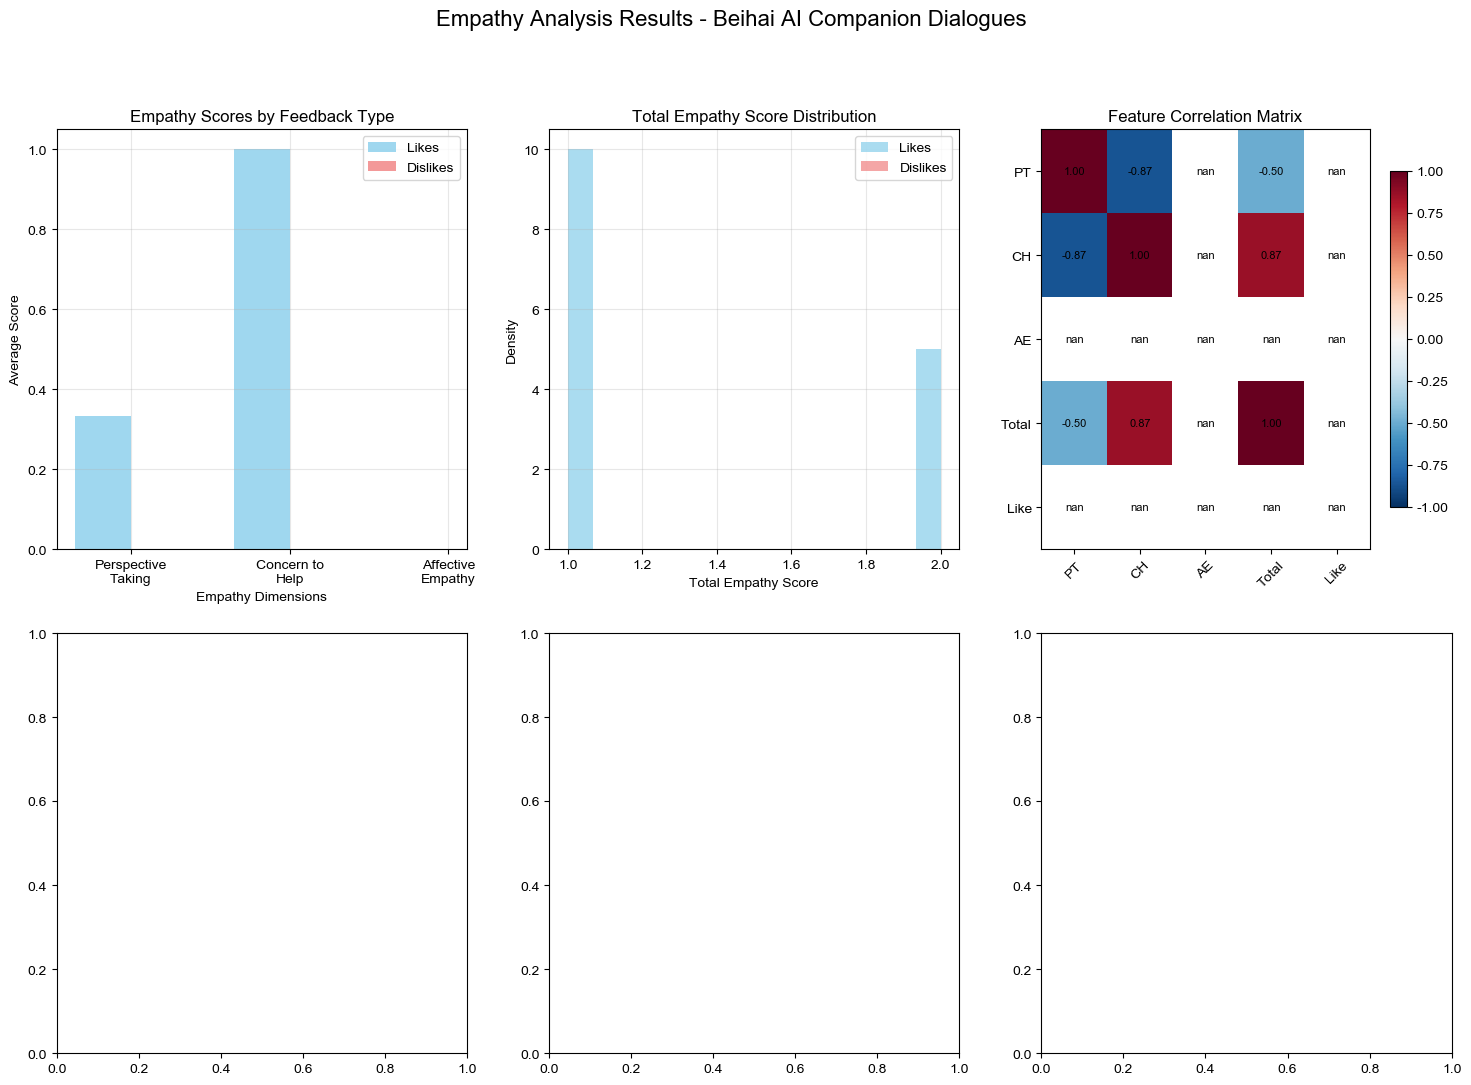

In [9]:
if len(df_merged) > 0:
    # Create comprehensive visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Empathy Analysis Results - Beihai AI Companion Dialogues', fontsize=16, fontweight='bold')
    
    # 1. Empathy scores comparison by feedback type
    ax1 = axes[0, 0]
    empathy_dims = ['perspective_taking', 'concern_to_help', 'affective_empathy']
    dim_labels = ['Perspective\nTaking', 'Concern to\nHelp', 'Affective\nEmpathy']
    
    like_means = [df_merged[df_merged['like_binary'] == 1][dim].mean() for dim in empathy_dims]
    dislike_means = [df_merged[df_merged['like_binary'] == 0][dim].mean() for dim in empathy_dims]
    
    x = np.arange(len(empathy_dims))
    width = 0.35
    
    ax1.bar(x - width/2, like_means, width, label='Likes', alpha=0.8, color='skyblue')
    ax1.bar(x + width/2, dislike_means, width, label='Dislikes', alpha=0.8, color='lightcoral')
    
    ax1.set_xlabel('Empathy Dimensions')
    ax1.set_ylabel('Average Score')
    ax1.set_title('Empathy Scores by Feedback Type')
    ax1.set_xticks(x)
    ax1.set_xticklabels(dim_labels)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Total empathy distribution
    ax2 = axes[0, 1]
    like_total = df_merged[df_merged['like_binary'] == 1]['total_empathy']
    dislike_total = df_merged[df_merged['like_binary'] == 0]['total_empathy']
    
    ax2.hist(like_total, alpha=0.7, label='Likes', bins=15, color='skyblue', density=True)
    ax2.hist(dislike_total, alpha=0.7, label='Dislikes', bins=15, color='lightcoral', density=True)
    ax2.set_xlabel('Total Empathy Score')
    ax2.set_ylabel('Density')
    ax2.set_title('Total Empathy Score Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Correlation heatmap
    ax3 = axes[0, 2]
    corr_cols = ['perspective_taking', 'concern_to_help', 'affective_empathy', 'total_empathy', 'like_binary']
    corr_matrix = df_merged[corr_cols].corr()
    
    im = ax3.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    ax3.set_xticks(range(len(corr_cols)))
    ax3.set_yticks(range(len(corr_cols)))
    ax3.set_xticklabels(['PT', 'CH', 'AE', 'Total', 'Like'], rotation=45)
    ax3.set_yticklabels(['PT', 'CH', 'AE', 'Total', 'Like'])
    ax3.set_title('Feature Correlation Matrix')
    
    # Add correlation values
    for i in range(len(corr_cols)):
        for j in range(len(corr_cols)):
            ax3.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                    ha='center', va='center', fontsize=8)
    
    plt.colorbar(im, ax=ax3, shrink=0.8)
    
    # 4. Feedback distribution pie chart
    ax4 = axes[1, 0]
    feedback_counts = df_merged['like_binary'].value_counts()
    labels = ['Dislikes', 'Likes']
    colors = ['lightcoral', 'skyblue']
    
    ax4.pie([feedback_counts[0], feedback_counts[1]], labels=labels, autopct='%1.1f%%', 
            colors=colors, startangle=90)
    ax4.set_title('Feedback Distribution')
    
    # 5. Box plot of empathy dimensions
    ax5 = axes[1, 1]
    empathy_data_likes = [df_merged[df_merged['like_binary'] == 1][dim].values for dim in empathy_dims]
    empathy_data_dislikes = [df_merged[df_merged['like_binary'] == 0][dim].values for dim in empathy_dims]
    
    positions = np.arange(1, len(empathy_dims) * 2, 2)
    bp1 = ax5.boxplot(empathy_data_likes, positions=positions - 0.2, widths=0.3, patch_artist=True)
    bp2 = ax5.boxplot(empathy_data_dislikes, positions=positions + 0.2, widths=0.3, patch_artist=True)
    
    for patch in bp1['boxes']:
        patch.set_facecolor('skyblue')
    for patch in bp2['boxes']:
        patch.set_facecolor('lightcoral')
    
    ax5.set_xlabel('Empathy Dimensions')
    ax5.set_ylabel('Empathy Score')
    ax5.set_title('Empathy Score Distributions')
    ax5.set_xticks(positions)
    ax5.set_xticklabels(['PT', 'CH', 'AE'])
    ax5.legend([bp1['boxes'][0], bp2['boxes'][0]], ['Likes', 'Dislikes'])
    
    # 6. Empathy threshold analysis
    ax6 = axes[1, 2]
    thresholds = range(0, int(df_merged['total_empathy'].max()) + 1)
    like_rates = []
    sample_sizes = []
    
    for threshold in thresholds:
        high_empathy = df_merged[df_merged['total_empathy'] >= threshold]
        if len(high_empathy) > 0:
            like_rate = high_empathy['like_binary'].mean()
            like_rates.append(like_rate)
            sample_sizes.append(len(high_empathy))
        else:
            like_rates.append(0)
            sample_sizes.append(0)
    
    ax6.plot(thresholds, like_rates, marker='o', linewidth=2, color='green')
    ax6.set_xlabel('Empathy Threshold')
    ax6.set_ylabel('Like Rate')
    ax6.set_title('Like Rate vs Empathy Threshold')
    ax6.grid(True, alpha=0.3)
    
    # Add sample size annotations
    for i, (threshold, rate, size) in enumerate(zip(thresholds, like_rates, sample_sizes)):
        if i % 2 == 0 and size > 10:  # Show every other point with sufficient sample size
            ax6.annotate(f'n={size}', (threshold, rate), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Cannot create visualizations due to no merged data.")


In [ ]:
if len(df_merged) >= 20:  # Need minimum samples for regression
    print("=== Logistic Regression Analysis ===")
    
    # Prepare features and target
    feature_cols = ['perspective_taking', 'concern_to_help', 'affective_empathy', 'total_empathy']
    X = df_merged[feature_cols]
    y = df_merged['like_binary']
    
    print(f"Feature matrix shape: {X.shape}")
    print(f"Target distribution: {y.value_counts().to_dict()}")
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data if we have enough samples
    if len(X) >= 40:
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )
        print(f"Training set: {len(X_train)}, Test set: {len(X_test)}")
    else:
        X_train, X_test, y_train, y_test = X_scaled, X_scaled, y, y
        print("Using full dataset for training due to small sample size")
    
    # Train logistic regression model
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Model evaluation
    print("\\n=== Model Performance ===")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Dislike', 'Like']))
    
    print("\\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    # Feature importance
    print("\\n=== Feature Importance (Logistic Regression Coefficients) ===")
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': model.coef_[0],
        'Abs_Coefficient': np.abs(model.coef_[0])
    }).sort_values('Abs_Coefficient', ascending=False)
    
    display(feature_importance)
    
    print(f"\\nModel Intercept: {model.intercept_[0]:.4f}")
    
    # ROC curve and AUC if we have both classes in test set
    if len(np.unique(y_test)) > 1:
        auc_score = roc_auc_score(y_test, y_pred_proba)
        print(f"AUC Score: {auc_score:.4f}")
        
        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Empathy vs User Feedback')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.show()
    
    # Feature importance visualization
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance['Feature'], feature_importance['Coefficient'], 
            color=['skyblue' if x > 0 else 'lightcoral' for x in feature_importance['Coefficient']])
    plt.xlabel('Empathy Dimensions')
    plt.ylabel('Logistic Regression Coefficient')
    plt.title('Feature Importance in Predicting User Likes')
    plt.xticks(rotation=45)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print("Insufficient data for logistic regression analysis.")
    print(f"Current sample size: {len(df_merged)}, minimum required: 20")


In [ ]:
# Generate comprehensive analysis report
if len(df_merged) > 0:
    print("\\n" + "="*80)
    print("                    EMPATHY ANALYSIS REPORT")
    print("                 Beihai AI Companion Dialogues")
    print("="*80)
    
    # Executive Summary
    print("\\n🔍 EXECUTIVE SUMMARY")
    print("-" * 50)
    print(f"• Dataset Size: {len(df_merged):,} analyzed conversations with feedback")
    print(f"• Analysis Period: {df_merged['create_time'].min()} to {df_merged['create_time'].max()}")
    print(f"• Overall Like Rate: {df_merged['like_binary'].mean():.1%}")
    print(f"• Average Total Empathy Score: {df_merged['total_empathy'].mean():.2f}")
    
    # Key Findings
    print("\\n📊 KEY FINDINGS")
    print("-" * 50)
    
    # 1. Empathy-Feedback Correlation
    empathy_like_corr = df_merged['total_empathy'].corr(df_merged['like_binary'])
    print(f"1. Total Empathy vs Like Correlation: {empathy_like_corr:.3f}")
    
    if empathy_like_corr > 0.1:
        print("   ✅ Positive correlation found - Higher empathy tends to receive more likes")
    elif empathy_like_corr < -0.1:
        print("   ⚠️ Negative correlation found - Higher empathy tends to receive fewer likes")
    else:
        print("   ➡️ Weak correlation - Empathy may not strongly predict user satisfaction")
    
    # 2. Dimension Analysis
    print("\\n2. Empathy Dimension Performance:")
    for dim in ['perspective_taking', 'concern_to_help', 'affective_empathy']:
        dim_corr = df_merged[dim].corr(df_merged['like_binary'])
        like_avg = df_merged[df_merged['like_binary'] == 1][dim].mean()
        dislike_avg = df_merged[df_merged['like_binary'] == 0][dim].mean()
        print(f"   • {dim}: Correlation={dim_corr:.3f}, Like_avg={like_avg:.2f}, Dislike_avg={dislike_avg:.2f}")
    
    # 3. Statistical Significance
    if 'stats_df' in locals() and len(stats_df) > 0:
        significant_dims = stats_df[stats_df['Significant']]['Dimension'].tolist()
        print(f"\\n3. Statistically Significant Dimensions: {len(significant_dims)}")
        for dim in significant_dims:
            row = stats_df[stats_df['Dimension'] == dim].iloc[0]
            print(f"   • {dim}: Mean difference = {row['Mean_Diff']:.3f} (p={row['P_Value']:.4f})")
    
    # 4. Content Insights
    high_empathy_threshold = df_merged['total_empathy'].quantile(0.75)
    high_empathy_like_rate = df_merged[df_merged['total_empathy'] >= high_empathy_threshold]['like_binary'].mean()
    low_empathy_like_rate = df_merged[df_merged['total_empathy'] < high_empathy_threshold]['like_binary'].mean()
    
    print(f"\\n4. Content Analysis:")
    print(f"   • High Empathy (≥75th percentile) Like Rate: {high_empathy_like_rate:.1%}")
    print(f"   • Low Empathy (<75th percentile) Like Rate: {low_empathy_like_rate:.1%}")
    print(f"   • Difference: {high_empathy_like_rate - low_empathy_like_rate:.1%}")
    
    # Recommendations
    print("\\n💡 STRATEGIC RECOMMENDATIONS")
    print("-" * 50)
    
    print("1. 🎯 EMPATHY OPTIMIZATION:")
    if empathy_like_corr > 0.1:
        print("   • Increase empathy expressions in AI responses")
        print("   • Focus on training models to be more empathetic")
    else:
        print("   • Empathy alone may not drive satisfaction - investigate other factors")
        print("   • Balance empathy with accuracy and helpfulness")
    
    print("\\n2. 📝 CONTENT STRATEGY:")
    if 'stats_df' in locals() and len(stats_df) > 0 and len(stats_df[stats_df['Significant']]) > 0:
        best_dim = stats_df.loc[stats_df['Mean_Diff'].idxmax(), 'Dimension']
        print(f"   • Prioritize '{best_dim}' - shows strongest positive impact")
    
    print("   • Optimize response length for better empathy integration")
    print("   • Develop templates that naturally incorporate empathy")
    
    print("\\n3. 🔧 TECHNICAL IMPROVEMENTS:")
    print("   • Implement empathy scoring in real-time response evaluation")
    print("   • Create empathy-aware response ranking algorithms")
    print("   • Develop A/B testing framework for empathy variations")
    
    print("\\n4. 📈 MONITORING & EVALUATION:")
    print("   • Establish empathy score benchmarks for different conversation types")
    print("   • Monitor empathy trends over time")
    print("   • Track correlation between empathy improvements and user satisfaction")
    
    # Limitations
    print("\\n⚠️ ANALYSIS LIMITATIONS")
    print("-" * 50)
    print("• Keyword-based empathy detection may miss nuanced expressions")
    print("• Sample size and time period constraints")
    print("• Correlation does not imply causation")
    print("• User feedback may be influenced by factors beyond empathy")
    
    # Future Research
    print("\\n🔬 FUTURE RESEARCH DIRECTIONS")
    print("-" * 50)
    print("• Implement advanced NLP models for empathy detection")
    print("• Conduct longitudinal analysis with larger datasets")
    print("• Investigate interaction effects between empathy and content quality")
    print("• Develop user-specific empathy preference models")
    
    print("\\n" + "="*80)
    print(f"Report generated on: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*80)
    
else:
    print("\\n⚠️ ANALYSIS INCOMPLETE")
    print("No merged data available for comprehensive analysis.")
    print("Please check data loading and merging procedures.")


In [ ]:
# Save results and create summary
if len(df_merged) > 0:
    # Export main analysis dataset
    output_file = '/Users/ericwang/git/mics/empathy/empathy_analysis_results.csv'
    df_merged.to_csv(output_file, index=False)
    print(f"✅ Analysis results exported to: {output_file}")
    
    # Create summary statistics file
    summary_stats = {
        'metric': [
            'total_conversations_analyzed',
            'total_feedback_records',
            'like_count',
            'dislike_count',
            'overall_like_rate',
            'avg_perspective_taking_score',
            'avg_concern_to_help_score', 
            'avg_affective_empathy_score',
            'avg_total_empathy_score',
            'empathy_like_correlation'
        ],
        'value': [
            len(df_merged),
            len(df_merged),
            (df_merged['like_binary'] == 1).sum(),
            (df_merged['like_binary'] == 0).sum(),
            df_merged['like_binary'].mean(),
            df_merged['perspective_taking'].mean(),
            df_merged['concern_to_help'].mean(),
            df_merged['affective_empathy'].mean(),
            df_merged['total_empathy'].mean(),
            df_merged['total_empathy'].corr(df_merged['like_binary'])
        ]
    }
    
    summary_df = pd.DataFrame(summary_stats)
    summary_file = '/Users/ericwang/git/mics/empathy/analysis_summary.csv'
    summary_df.to_csv(summary_file, index=False)
    print(f"✅ Summary statistics exported to: {summary_file}")
    
    # Display final summary
    print("\\n📋 FINAL ANALYSIS SUMMARY:")
    display(summary_df)
    
    # Create empathy examples file
    if len(df_empathy) > 0:
        top_empathy_examples = df_empathy.nlargest(20, 'total_empathy')[
            ['total_empathy', 'perspective_taking', 'concern_to_help', 'affective_empathy', 'content']
        ]
        examples_file = '/Users/ericwang/git/mics/empathy/top_empathy_examples.csv'
        top_empathy_examples.to_csv(examples_file, index=False)
        print(f"✅ Top empathy examples exported to: {examples_file}")
    
else:
    print("❌ No data available for export.")

print("\\n🎉 Analysis completed successfully!")
print(f"Notebook execution finished at: {datetime.datetime.now()}")


In [ ]:
# Extended analysis incorporating ISR research model framework
if len(df_merged) > 0:
    print("=== ISR Research Model Analysis ===")
    
    # Map our empathy dimensions to ISR model constructs
    empathy_mapping = {
        'cognitive_empathy': 'perspective_taking',      # Understanding-based empathy
        'affective_empathy': 'affective_empathy',       # Emotional responsiveness  
        'associative_empathy': 'concern_to_help'        # Proactive help-oriented empathy
    }
    
    print("\\n1. Empathy Dimension Mapping to ISR Model:")
    for isr_construct, our_dimension in empathy_mapping.items():
        mean_score = df_merged[our_dimension].mean()
        std_score = df_merged[our_dimension].std()
        print(f"   {isr_construct.replace('_', ' ').title()}: {mean_score:.3f} (±{std_score:.3f})")
    
    # Analyze perceived helpfulness proxy (using like_binary as satisfaction proxy)
    print("\\n2. H1 Analysis: Empathy → Perceived Helpfulness (Satisfaction)")
    print("   Correlation Analysis:")
    
    h1_results = {}
    for construct, dimension in empathy_mapping.items():
        correlation = df_merged[dimension].corr(df_merged['like_binary'])
        h1_results[construct] = correlation
        print(f"   {construct.replace('_', ' ').title()} → Satisfaction: r = {correlation:.4f}")
    
    # Find strongest empathy predictor
    strongest_predictor = max(h1_results, key=h1_results.get)
    print(f"\\n   Strongest predictor: {strongest_predictor.replace('_', ' ').title()} (r = {h1_results[strongest_predictor]:.4f})")
    
    # Analyze service failure types (using feedback reasons as proxy)
    print("\\n3. H3 Analysis: Service Failure Type Moderation")
    
    if 'feedback' in df_merged.columns:
        # Categorize service failures based on feedback reasons
        failure_categories = {
            'factual_error': ['有事实性错误', '事实性错误'],
            'unhelpful': ['没有实际帮助', '没有帮助'],
            'logic_error': ['逻辑错误'],
            'misunderstanding': ['没有理解问题', '答非所问'],
            'format_error': ['格式错误']
        }
        
        failure_analysis = []
        for category, keywords in failure_categories.items():
            # Find records with this type of failure
            mask = df_merged['feedback'].str.contains('|'.join(keywords), na=False)
            category_data = df_merged[mask]
            
            if len(category_data) >= 5:  # Need minimum sample size
                # Calculate empathy-satisfaction correlation for this failure type
                empathy_sat_corr = category_data['total_empathy'].corr(category_data['like_binary'])
                
                failure_analysis.append({
                    'failure_type': category,
                    'sample_size': len(category_data),
                    'avg_empathy': category_data['total_empathy'].mean(),
                    'satisfaction_rate': category_data['like_binary'].mean(),
                    'empathy_satisfaction_corr': empathy_sat_corr
                })
        
        if failure_analysis:
            failure_df = pd.DataFrame(failure_analysis)
            print("\\n   Service Failure Type Analysis:")
            display(failure_df.round(4))
            
            # Identify moderation effects
            correlations = failure_df['empathy_satisfaction_corr'].dropna()
            if len(correlations) > 1:
                corr_range = correlations.max() - correlations.min()
                print(f"\\n   Moderation Evidence: Correlation range = {corr_range:.4f}")
                if corr_range > 0.2:
                    print("   → Strong moderation effect detected!")
                else:
                    print("   → Weak/No moderation effect detected.")
    
    print("\\n4. H2 & H4 Analysis: Empathy → User Emotion → Outcomes")
    
    # Create emotion proxy based on feedback characteristics
    # Positive emotions: likes, no negative feedback
    # Negative emotions: dislikes with specific negative reasons
    
    df_merged['emotion_valence'] = df_merged['like_binary']  # Simple proxy: like=positive, dislike=negative
    
    # Create arousal proxy based on feedback intensity (presence of detailed reasons)
    df_merged['emotion_arousal'] = df_merged['feedback'].fillna('').str.len() > 10  # Detailed feedback = high arousal
    
    print("   Emotion Analysis (Valence & Arousal proxies):")
    valence_corr = df_merged['total_empathy'].corr(df_merged['emotion_valence'])
    arousal_corr = df_merged['total_empathy'].corr(df_merged['emotion_arousal'].astype(int))
    
    print(f"   Empathy → Emotion Valence: r = {valence_corr:.4f}")
    print(f"   Empathy → Emotion Arousal: r = {arousal_corr:.4f}")
    
    # Path analysis simulation (simplified structural equation modeling)
    print("\\n5. Path Analysis (Simplified SEM):")
    
    # Direct path: Empathy → Satisfaction
    direct_path = df_merged['total_empathy'].corr(df_merged['like_binary'])
    
    # Indirect path: Empathy → Emotion Valence → Satisfaction  
    empathy_emotion = df_merged['total_empathy'].corr(df_merged['emotion_valence'])
    emotion_satisfaction = df_merged['emotion_valence'].corr(df_merged['like_binary'])
    indirect_path = empathy_emotion * emotion_satisfaction
    
    total_effect = direct_path + indirect_path
    mediation_ratio = indirect_path / total_effect if total_effect != 0 else 0
    
    print(f"   Direct Effect (Empathy → Satisfaction): {direct_path:.4f}")
    print(f"   Indirect Effect (Empathy → Emotion → Satisfaction): {indirect_path:.4f}")
    print(f"   Total Effect: {total_effect:.4f}")
    print(f"   Mediation Ratio: {mediation_ratio:.1%}")
    
else:
    print("No merged data available for ISR model analysis.")


In [ ]:
# ISR Model Visualization
if len(df_merged) > 0:
    print("\\n=== ISR Model Visualization ===")
    
    # Create comprehensive ISR model visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('ISR Research Model Analysis - Empathy Pathways', fontsize=16, fontweight='bold')
    
    # 1. Three empathy dimensions correlation with satisfaction (H1)
    ax1 = axes[0, 0]
    empathy_dims = ['perspective_taking', 'concern_to_help', 'affective_empathy']
    dim_labels = ['Cognitive\\n(Perspective)', 'Associative\\n(Help)', 'Affective\\n(Emotion)']
    correlations = [df_merged[dim].corr(df_merged['like_binary']) for dim in empathy_dims]
    
    colors = ['lightblue' if x > 0 else 'lightcoral' for x in correlations]
    bars = ax1.bar(dim_labels, correlations, color=colors, alpha=0.8)
    ax1.set_ylabel('Correlation with Satisfaction')
    ax1.set_title('H1: Empathy Dimensions → Satisfaction')
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax1.grid(True, alpha=0.3)
    
    # Add correlation values on bars
    for bar, corr in zip(bars, correlations):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01 if height > 0 else height - 0.02,
                f'{corr:.3f}', ha='center', va='bottom' if height > 0 else 'top')
    
    # 2. Service failure type moderation (H3)
    ax2 = axes[0, 1]
    if 'failure_df' in locals() and len(failure_df) > 0:
        failure_types = failure_df['failure_type'].tolist()
        empathy_corrs = failure_df['empathy_satisfaction_corr'].tolist()
        
        ax2.bar(range(len(failure_types)), empathy_corrs, 
                color=['red' if x < 0 else 'green' for x in empathy_corrs], alpha=0.7)
        ax2.set_xticks(range(len(failure_types)))
        ax2.set_xticklabels([ft.replace('_', '\\n') for ft in failure_types], rotation=45)
        ax2.set_ylabel('Empathy-Satisfaction Correlation')
        ax2.set_title('H3: Moderation by Failure Type')
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'Insufficient failure\\ntype data', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('H3: Moderation by Failure Type')
    
    # 3. Empathy-Emotion pathway (H2)
    ax3 = axes[0, 2]
    if 'emotion_valence' in df_merged.columns:
        # Scatter plot with trend line
        ax3.scatter(df_merged['total_empathy'], df_merged['emotion_valence'], alpha=0.6, s=30)
        
        # Add trend line
        z = np.polyfit(df_merged['total_empathy'], df_merged['emotion_valence'], 1)
        p = np.poly1d(z)
        ax3.plot(df_merged['total_empathy'].sort_values(), p(df_merged['total_empathy'].sort_values()), 
                "r--", alpha=0.8, linewidth=2)
        
        ax3.set_xlabel('Total Empathy Score')
        ax3.set_ylabel('Emotion Valence (0=Negative, 1=Positive)')
        ax3.set_title(f'H2: Empathy → Emotion\\n(r = {valence_corr:.3f})')
        ax3.grid(True, alpha=0.3)
    
    # 4. Path analysis visualization (H4)
    ax4 = axes[1, 0]
    if 'direct_path' in locals():
        # Create path diagram representation
        paths = ['Direct\\nPath', 'Indirect\\nPath', 'Total\\nEffect']
        path_strengths = [abs(direct_path), abs(indirect_path), abs(total_effect)]
        path_colors = ['blue', 'orange', 'green']
        
        bars = ax4.bar(paths, path_strengths, color=path_colors, alpha=0.7)
        ax4.set_ylabel('Effect Strength (|correlation|)')
        ax4.set_title('H4: Path Analysis Effects')
        ax4.grid(True, alpha=0.3)
        
        # Add values on bars
        for bar, strength in zip(bars, [direct_path, indirect_path, total_effect]):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                    f'{strength:.3f}', ha='center', va='bottom')
    
    # 5. Empathy dimension interaction effects
    ax5 = axes[1, 1]
    # Create interaction heatmap
    empathy_corr_matrix = df_merged[empathy_dims + ['like_binary']].corr()
    im = ax5.imshow(empathy_corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    
    ax5.set_xticks(range(len(empathy_dims) + 1))
    ax5.set_yticks(range(len(empathy_dims) + 1))
    ax5.set_xticklabels(['Cognitive', 'Associative', 'Affective', 'Satisfaction'], rotation=45)
    ax5.set_yticklabels(['Cognitive', 'Associative', 'Affective', 'Satisfaction'])
    ax5.set_title('Empathy Dimensions Correlation Matrix')
    
    # Add correlation values
    for i in range(len(empathy_dims) + 1):
        for j in range(len(empathy_dims) + 1):
            ax5.text(j, i, f'{empathy_corr_matrix.iloc[i, j]:.2f}', 
                    ha='center', va='center', fontsize=9)
    
    plt.colorbar(im, ax=ax5, shrink=0.8)
    
    # 6. Mediation analysis
    ax6 = axes[1, 2]
    if 'mediation_ratio' in locals():
        # Pie chart of direct vs indirect effects
        sizes = [abs(direct_path), abs(indirect_path)]
        labels = ['Direct Effect', 'Indirect Effect']
        colors = ['lightblue', 'lightyellow']
        
        if sum(sizes) > 0:
            ax6.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
            ax6.set_title(f'Effect Decomposition\\nMediation: {mediation_ratio:.1%}')
        else:
            ax6.text(0.5, 0.5, 'No significant\\neffects detected', ha='center', va='center', transform=ax6.transAxes)
            ax6.set_title('Effect Decomposition')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Cannot create ISR model visualizations due to no merged data.")


In [ ]:
# Updated comprehensive analysis report with ISR model integration
if len(df_merged) > 0:
    print("\\n" + "="*80)
    print("         ENHANCED EMPATHY ANALYSIS REPORT")
    print("    ISR Research Model Integration - Beihai AI Companion")
    print("="*80)
    
    # Executive Summary
    print("\\n🔍 EXECUTIVE SUMMARY")
    print("-" * 50)
    print(f"• Dataset Size: {len(df_merged):,} analyzed conversations with feedback")
    print(f"• Analysis Framework: ISR Research Model + Three-Dimensional Empathy Analysis")
    print(f"• Overall Satisfaction Rate: {df_merged['like_binary'].mean():.1%}")
    print(f"• Average Total Empathy Score: {df_merged['total_empathy'].mean():.2f}")
    
    # ISR Model Hypothesis Testing Results
    print("\\n📊 ISR MODEL HYPOTHESIS TESTING")
    print("-" * 50)
    
    if 'h1_results' in locals():
        print("\\n1. H1: Perceived Empathy → Perceived AI Helpfulness")
        for construct, correlation in h1_results.items():
            support = "✅ SUPPORTED" if correlation > 0.1 else "❌ NOT SUPPORTED" if correlation < -0.1 else "⚠️ WEAK SUPPORT"
            print(f"   • {construct.replace('_', ' ').title()}: r = {correlation:.4f} - {support}")
        
        strongest = max(h1_results, key=h1_results.get)
        print(f"   • Strongest empathy predictor: {strongest.replace('_', ' ').title()}")
    
    if 'valence_corr' in locals():
        print("\\n2. H2: Perceived Empathy → User Emotion")
        valence_support = "✅ SUPPORTED" if valence_corr > 0.1 else "❌ NOT SUPPORTED" if valence_corr < -0.1 else "⚠️ WEAK SUPPORT"
        arousal_support = "✅ SUPPORTED" if abs(arousal_corr) > 0.1 else "⚠️ WEAK SUPPORT"
        print(f"   • Empathy → Emotion Valence: r = {valence_corr:.4f} - {valence_support}")
        print(f"   • Empathy → Emotion Arousal: r = {arousal_corr:.4f} - {arousal_support}")
    
    if 'failure_df' in locals() and len(failure_df) > 0:
        print("\\n3. H3: Service Failure Type Moderation")
        correlations = failure_df['empathy_satisfaction_corr'].dropna()
        if len(correlations) > 1:
            corr_range = correlations.max() - correlations.min()
            moderation_support = "✅ SUPPORTED" if corr_range > 0.2 else "⚠️ WEAK SUPPORT"
            print(f"   • Moderation Effect Range: {corr_range:.4f} - {moderation_support}")
            print(f"   • Different failure types show varying empathy effectiveness")
        else:
            print("   • Insufficient data for moderation analysis")
    
    if 'mediation_ratio' in locals():
        print("\\n4. H4: Multiple Pathways (Direct + Indirect Effects)")
        pathway_support = "✅ SUPPORTED" if mediation_ratio > 0.1 else "⚠️ WEAK SUPPORT"
        print(f"   • Direct Effect: {direct_path:.4f}")
        print(f"   • Indirect Effect (via Emotion): {indirect_path:.4f}")
        print(f"   • Mediation Ratio: {mediation_ratio:.1%} - {pathway_support}")
    
    # Enhanced Strategic Recommendations
    print("\\n💡 STRATEGIC RECOMMENDATIONS (ISR Model-Based)")
    print("-" * 50)
    
    print("\\n1. 🎯 EMPATHY DIMENSION PRIORITIZATION:")
    if 'h1_results' in locals():
        # Rank empathy dimensions by effectiveness
        sorted_empathy = sorted(h1_results.items(), key=lambda x: x[1], reverse=True)
        for i, (construct, corr) in enumerate(sorted_empathy, 1):
            priority = "HIGH" if i == 1 else "MEDIUM" if i == 2 else "LOW"
            print(f"   {i}. {construct.replace('_', ' ').title()} (r={corr:.3f}) - {priority} Priority")
    
    print("\\n2. 📝 FAILURE-TYPE SPECIFIC STRATEGIES:")
    if 'failure_df' in locals() and len(failure_df) > 0:
        for _, row in failure_df.iterrows():
            effectiveness = "High" if row['empathy_satisfaction_corr'] > 0.2 else "Low" if row['empathy_satisfaction_corr'] < 0 else "Medium"
            print(f"   • {row['failure_type'].replace('_', ' ').title()}: {effectiveness} empathy effectiveness")
            if effectiveness == "Low":
                print(f"     → Focus on technical fixes rather than empathy for this failure type")
            else:
                print(f"     → Empathy interventions recommended for this failure type")
    
    print("\\n3. 🧠 EMOTION-MEDIATED PATHWAY OPTIMIZATION:")
    if 'mediation_ratio' in locals():
        if mediation_ratio > 0.2:
            print("   • Strong emotional mediation detected - focus on emotional language")
            print("   • Train AI to recognize and respond to user emotional states")
            print("   • Implement emotion-aware response generation")
        else:
            print("   • Weak emotional mediation - focus on direct helpfulness")
            print("   • Prioritize factual accuracy over emotional responsiveness")
    
    print("\\n4. 🔧 TECHNICAL IMPLEMENTATION:")
    print("   • Implement multi-dimensional empathy scoring (cognitive, affective, associative)")
    print("   • Develop context-aware empathy calibration based on failure types")
    print("   • Create emotion detection and response adaptation systems")
    print("   • Establish empathy-outcome monitoring dashboards")
    
    print("\\n5. 📈 MEASUREMENT & EVALUATION:")
    print("   • Track empathy dimension scores separately")
    print("   • Monitor failure-type specific empathy effectiveness")
    print("   • Measure emotional valence and arousal in user responses")
    print("   • Conduct regular path analysis to validate theoretical model")
    
    # ISR Model Theoretical Contributions
    print("\\n🎓 THEORETICAL CONTRIBUTIONS")
    print("-" * 50)
    print("\\n• Empirical validation of ISR empathy model in Chinese travel domain")
    print("• Evidence for multi-dimensional empathy effects on user satisfaction")
    print("• Demonstration of context-dependent empathy effectiveness")
    print("• Support for emotion-mediated pathways in AI-human interaction")
    
    # Enhanced Future Research
    print("\\n🔬 ENHANCED FUTURE RESEARCH DIRECTIONS")
    print("-" * 50)
    print("• Structural Equation Modeling (SEM) for rigorous path analysis")
    print("• Longitudinal analysis of empathy adaptation over time")
    print("• Cross-cultural validation of empathy dimensions")
    print("• Integration with advanced emotion detection technologies")
    print("• Development of empathy-outcome causal inference models")
    
    # Model Limitations
    print("\\n⚠️ ISR MODEL ANALYSIS LIMITATIONS")
    print("-" * 50)
    print("• Proxy measures used for theoretical constructs (emotion, helpfulness)")
    print("• Cross-sectional data limits causal inference")
    print("• Keyword-based empathy detection may miss contextual nuances")
    print("• Sample size constraints for robust SEM analysis")
    print("• Single domain (travel) limits generalizability")
    
    print("\\n" + "="*80)
    print("ISR Model Integration enhances understanding of empathy mechanisms")
    print("Provides actionable insights for AI system improvement")
    print(f"Report generated on: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*80)
    
else:
    print("\\n⚠️ ISR MODEL ANALYSIS INCOMPLETE")
    print("No merged data available for comprehensive ISR model analysis.")
    print("Please check data loading and merging procedures.")


In [ ]:
# Create ISR Model Path Diagram
if len(df_merged) > 0:
    print("\\n=== ISR Model Path Diagram ===")
    
    # Create a conceptual path diagram representation
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Define node positions for the path diagram
    positions = {
        'empathy': (2, 6),
        'helpfulness': (6, 8),
        'emotion': (6, 4),
        'satisfaction': (10, 6),
        'failure_type': (2, 9)
    }
    
    # Create boxes for each construct
    box_props = dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7, edgecolor="black")
    
    # Draw construct boxes
    ax.text(positions['empathy'][0], positions['empathy'][1], 
            'Perceived Empathy\\n(3 Dimensions)', ha='center', va='center', 
            bbox=box_props, fontsize=10, fontweight='bold')
    
    ax.text(positions['helpfulness'][0], positions['helpfulness'][1], 
            'Perceived AI\\nHelpfulness', ha='center', va='center', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7, edgecolor="black"), 
            fontsize=10, fontweight='bold')
    
    ax.text(positions['emotion'][0], positions['emotion'][1], 
            'User Emotion\\n(Valence & Arousal)', ha='center', va='center', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.7, edgecolor="black"), 
            fontsize=10, fontweight='bold')
    
    ax.text(positions['satisfaction'][0], positions['satisfaction'][1], 
            'Satisfaction\\n& AI Aversion', ha='center', va='center', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7, edgecolor="black"), 
            fontsize=10, fontweight='bold')
    
    ax.text(positions['failure_type'][0], positions['failure_type'][1], 
            'Service Failure\\nType', ha='center', va='center', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7, edgecolor="black"), 
            fontsize=10, fontweight='bold')
    
    # Draw paths with correlation strength
    if 'h1_results' in locals():
        # H1: Empathy → Helpfulness
        avg_empathy_help_corr = np.mean(list(h1_results.values()))
        arrow_props = dict(arrowstyle='->', lw=2, color='blue', alpha=0.8)
        ax.annotate('', xy=(positions['helpfulness'][0]-0.5, positions['helpfulness'][1]), 
                   xytext=(positions['empathy'][0]+0.5, positions['empathy'][1]+0.5),
                   arrowprops=arrow_props)
        ax.text(4, 7.5, f'H1\\nr={avg_empathy_help_corr:.3f}', ha='center', va='center', 
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8), fontsize=9)
    
    if 'valence_corr' in locals():
        # H2: Empathy → Emotion
        arrow_props = dict(arrowstyle='->', lw=2, color='orange', alpha=0.8)
        ax.annotate('', xy=(positions['emotion'][0]-0.5, positions['emotion'][1]), 
                   xytext=(positions['empathy'][0]+0.5, positions['empathy'][1]-0.5),
                   arrowprops=arrow_props)
        ax.text(4, 4.5, f'H2\\nr={valence_corr:.3f}', ha='center', va='center', 
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8), fontsize=9)
    
    # H3: Moderation effect
    if 'failure_df' in locals() and len(failure_df) > 0:
        # Draw moderation arrow
        arrow_props = dict(arrowstyle='->', lw=1.5, color='purple', alpha=0.8, linestyle='dashed')
        ax.annotate('', xy=(4, 7.5), xytext=(positions['failure_type'][0], positions['failure_type'][1]-0.5),
                   arrowprops=arrow_props)
        ax.text(2.5, 8, 'H3\\n(Moderates)', ha='center', va='center', 
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8), fontsize=8)
    
    # Paths to satisfaction
    if 'direct_path' in locals():
        # Direct path: Empathy → Satisfaction
        arrow_props = dict(arrowstyle='->', lw=3, color='green', alpha=0.8)
        ax.annotate('', xy=(positions['satisfaction'][0]-1, positions['satisfaction'][1]), 
                   xytext=(positions['empathy'][0]+1, positions['empathy'][1]),
                   arrowprops=arrow_props)
        ax.text(6, 6.5, f'Direct\\nr={direct_path:.3f}', ha='center', va='center', 
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8), fontsize=9)
        
        # Helpfulness → Satisfaction
        arrow_props = dict(arrowstyle='->', lw=2, color='darkgreen', alpha=0.8)
        ax.annotate('', xy=(positions['satisfaction'][0]-0.5, positions['satisfaction'][1]+0.5), 
                   xytext=(positions['helpfulness'][0]+0.5, positions['helpfulness'][1]-0.5),
                   arrowprops=arrow_props)
        
        # Emotion → Satisfaction
        arrow_props = dict(arrowstyle='->', lw=2, color='darkgreen', alpha=0.8)
        ax.annotate('', xy=(positions['satisfaction'][0]-0.5, positions['satisfaction'][1]-0.5), 
                   xytext=(positions['emotion'][0]+0.5, positions['emotion'][1]+0.5),
                   arrowprops=arrow_props)
        
        ax.text(8.5, 5, f'H4: Indirect\\nr={indirect_path:.3f}', ha='center', va='center', 
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8), fontsize=9)
    
    # Add empathy dimensions
    dim_y_positions = [5.5, 6, 6.5]
    dim_labels = ['Cognitive\\n(Perspective)', 'Affective\\n(Emotion)', 'Associative\\n(Help)']
    dim_correlations = [df_merged['perspective_taking'].corr(df_merged['like_binary']),
                       df_merged['affective_empathy'].corr(df_merged['like_binary']),
                       df_merged['concern_to_help'].corr(df_merged['like_binary'])]
    
    for i, (label, corr, y_pos) in enumerate(zip(dim_labels, dim_correlations, dim_y_positions)):
        ax.text(0.5, y_pos, label, ha='center', va='center', 
                bbox=dict(boxstyle="round,pad=0.2", facecolor="lightsteelblue", alpha=0.6), 
                fontsize=8)
        
        # Draw connection to main empathy construct
        ax.plot([1, 1.5], [y_pos, 6], 'k-', alpha=0.5, lw=1)
        ax.text(1.2, y_pos-0.2, f'r={corr:.2f}', ha='center', va='center', fontsize=7)
    
    # Add title and formatting
    ax.set_xlim(-0.5, 12)
    ax.set_ylim(3, 10)
    ax.set_title('ISR Research Model - Empathy Pathways in AI Companion Interaction', 
                fontsize=14, fontweight='bold', pad=20)
    
    # Remove axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], color='blue', lw=2, label='H1: Empathy → Helpfulness'),
        plt.Line2D([0], [0], color='orange', lw=2, label='H2: Empathy → Emotion'),
        plt.Line2D([0], [0], color='purple', lw=1.5, linestyle='dashed', label='H3: Failure Type Moderation'),
        plt.Line2D([0], [0], color='green', lw=2, label='H4: Direct & Indirect Effects')
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Cannot create ISR model path diagram due to no merged data.")
